In [1]:
import re
import numpy as np
import pandas as pd
import networkx as nx
import community
import markov_clustering as markov
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from scipy import sparse
from wordcloud import WordCloud
from modules.network import load_edges, get_degree

# Get default colors
colors = [*mcolors.TABLEAU_COLORS.values()]

%matplotlib inline

In [2]:
# Define periods under analysis
years = [2017, 2018]

In [3]:
# Load dictionaries mapping indices to lemma tuples
w2i = np.load('data/edges_w2i.npy', allow_pickle=True).item()
i2w = np.load('data/edges_i2w.npy', allow_pickle=True).item()

In [4]:
# Load edges
edges = {y: pd.read_csv('data/database/edges_{:d}.csv'.format(y)) for y in years}

In [5]:
# Check edges 2017
edges[2017].head()

,node_x,node_y,counts
0,0,654,1
1,0,2466,1
2,0,2469,1
3,4,210,1
4,4,1076,1


In [6]:
# Check edges 2018
edges[2018].head()

,node_x,node_y,counts
0,1,227,1
1,1,323,1
2,1,772,1
3,1,1000,1
4,1,1429,1


In [7]:
# Create undirected multigraph objects using edges table
networks = {}
for y in years:
    networks[y] = nx.from_pandas_edgelist(edges[y], source='node_x', target='node_y', 
                                          edge_attr='counts', create_using=nx.MultiGraph)

In [8]:
# Define colors and labels for each POS tag
pos_patches = {
    'N': (colors[0], 'Noun'),  # Noun
    'V': (colors[1], 'Verb'),  # Verb
    'A': (colors[2], 'Adjective'),  # Adjective
    'R': (colors[3], 'Adverb')   # Adverb
}

# Define function for plotting cluster wordcloud
def make_word_cloud(word_cloud, scores):
    """
    Input:
    - Lemmas: list of tuples (word text, pos tag)
    - Scores: list of scores which define word importance
    Note that len(scores) = len(lemmas) must be satisfied
    Output:
    - WordCloud object
    """
    
    # Use words only to define word positions
    word_cloud = word_cloud.generate_from_frequencies(
        {word_text: score for (word_text, pos_tag), score in scores.items()}
    )
    
    # Modify layout
    for i, (word, font_size, position, orientation, color) in enumerate(word_cloud.layout_):
        # Get text and pos tag, separated
        pos_tag = scores.index[i][1]
        word_cloud.layout_[i] = (word, font_size, position, orientation, pos_patches[pos_tag][0])
    
    # Return modified wordcloud object
    return word_cloud

# MCL communities extraction

In [9]:
# MCL parameters

# Inflaction: float > 1
imin = 15       # minimum inflaction * 10
imax = 40       # maximum inflaction * 10
istep = 5       # step for inflaction exploration * 10

# Expansion: integer > 1
emin = 2        # minimum expansion 
emax = 8        # maximum expansion 
estep = 1       # step for expansion exploration

max_iter = 500  # max number of iterations for the algorithm

In [10]:
# Evaluate modularity for each set of parameters

# for k in adj_matrices.keys():
#    # convert the matrix to sparse
#    mat = sparse.csr_matrix(adj_matrices[k])
#    print('{:s}\'s network'.format(k))
#    # Grid search for best parameters
#    for inf in [i / 10 for i in range(imin, imax, istep)]:
#        for exp in [e for e in range(emin, emax, estep)]:
#            # Compute clusters
#            result = markov.run_mcl(mat, pruning_threshold = 0, iterations = max_iter, inflation = inf, expansion = exp) 
#            clusters = markov.get_clusters(mat) 
#            print("Num. clusters:",len(clusters))
#            # Compute corresponding modularity
#            Q = markov.modularity(matrix=result, clusters=clusters)
#            print("inflation:", inf, "expansion:", exp, "modularity:", Q) 

In [11]:
# Second evaluation: only on 2018 net
#
# print('\n\n2018\'s network')
# # convert the matrix to sparse
# mat = sparse.csr_matrix(X[1])
# exp = 2
# inf_range = [40, 120]
# for inf in [i/10 for i in range(inf_range[0], inf_range[1], 10)]:
#    # Compute clusters
#    result = markov.run_mcl(mat, pruning_threshold = 0, iterations = max_iter, inflation = inf, expansion = exp ) 
#    clusters = markov.get_clusters(mat) 
#    print("Num. clusters:",len(clusters))
#    # Compute corresponding modularity
#    Q = markov.modularity(matrix=result, clusters=clusters)
#    print("inflation:", inf, "expansion:", exp, "modularity:", Q) 

In [12]:
# Best parameters
params = {
    2017: {'inf': 1.5, 'exp': 4},  # mod = 0.0011712948963333333, n. clusters 48
    2018: {'inf': 3.5, 'exp': 2}   # mod = 0.023 (?) , n. clusters 112
}

# Other parameters can be tried: 
# - 2018: higher inf

In [13]:
# Compute and print clusters

mcl_clusters = {}

for y in years:
    # Retrieve adjacency matrix
    adj_matrix = nx.to_numpy_matrix(networks[y], weight='counts')
    # Convert the matrix to sparse
    adj_matrix = sparse.csr_matrix(adj_matrix)
    # MCL using best parameters
    result = markov.run_mcl(adj_matrix, verbose = 1, pruning_threshold = 0, iterations = max_iter, 
                            inflation = params[y]['inf'], expansion = params[y]['exp']) 
    # Retrieve clusters according to dimension
    clusters = sorted(markov.get_clusters(adj_matrix), key=len, reverse=True)
    # Save clusters
    mcl_clusters[y] = clusters

--------------------------------------------------
MCL Parameters
Expansion: 4
Inflation: 1.5
No pruning
Convergence check: 1 iteration
Maximum iterations: 500
Sparse matrix mode
--------------------------------------------------
Iteration 1
Checking for convergence
Iteration 2
Checking for convergence
Iteration 3
Checking for convergence
Iteration 4
Checking for convergence
Iteration 5
Checking for convergence
Iteration 6
Checking for convergence
Iteration 7
Checking for convergence
Iteration 8
Checking for convergence
Converged after 8 iterations
--------------------------------------------------
--------------------------------------------------
MCL Parameters
Expansion: 2
Inflation: 3.5
No pruning
Convergence check: 1 iteration
Maximum iterations: 500
Sparse matrix mode
--------------------------------------------------
Iteration 1
Checking for convergence
Iteration 2
Checking for convergence
Iteration 3
Checking for convergence
Iteration 4
Checking for convergence
Iteration 5
Chec

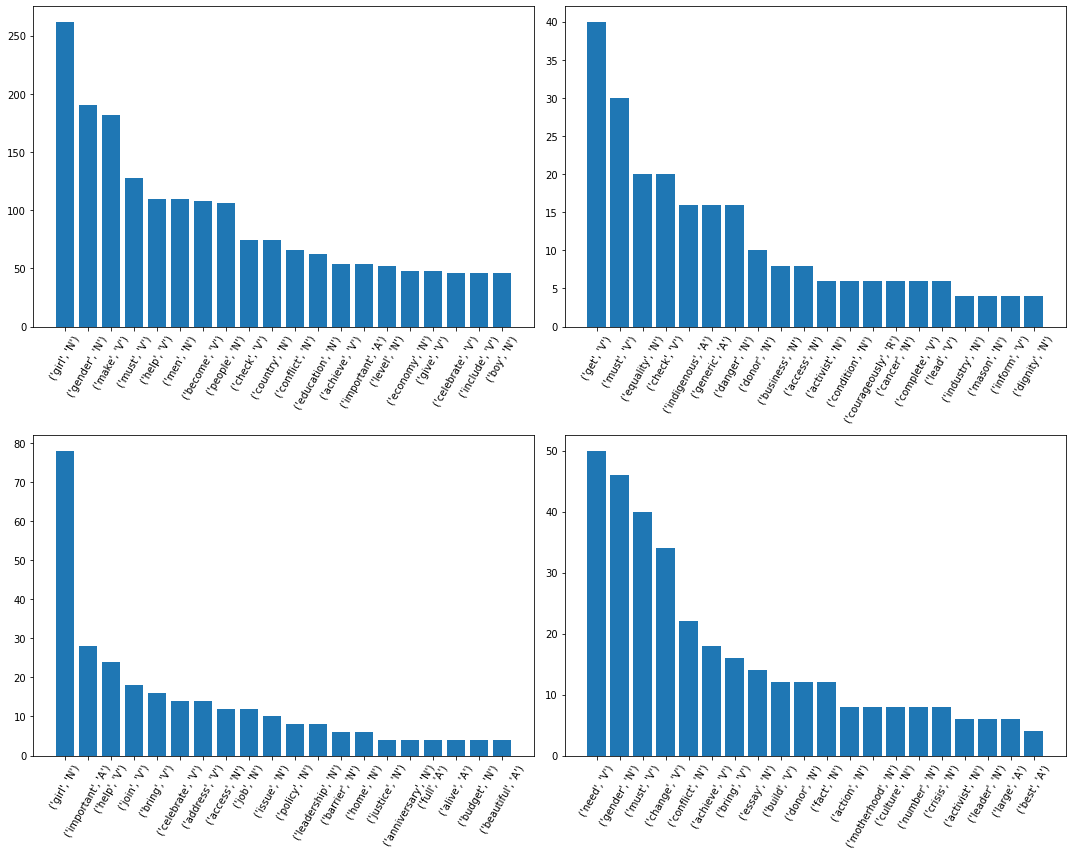

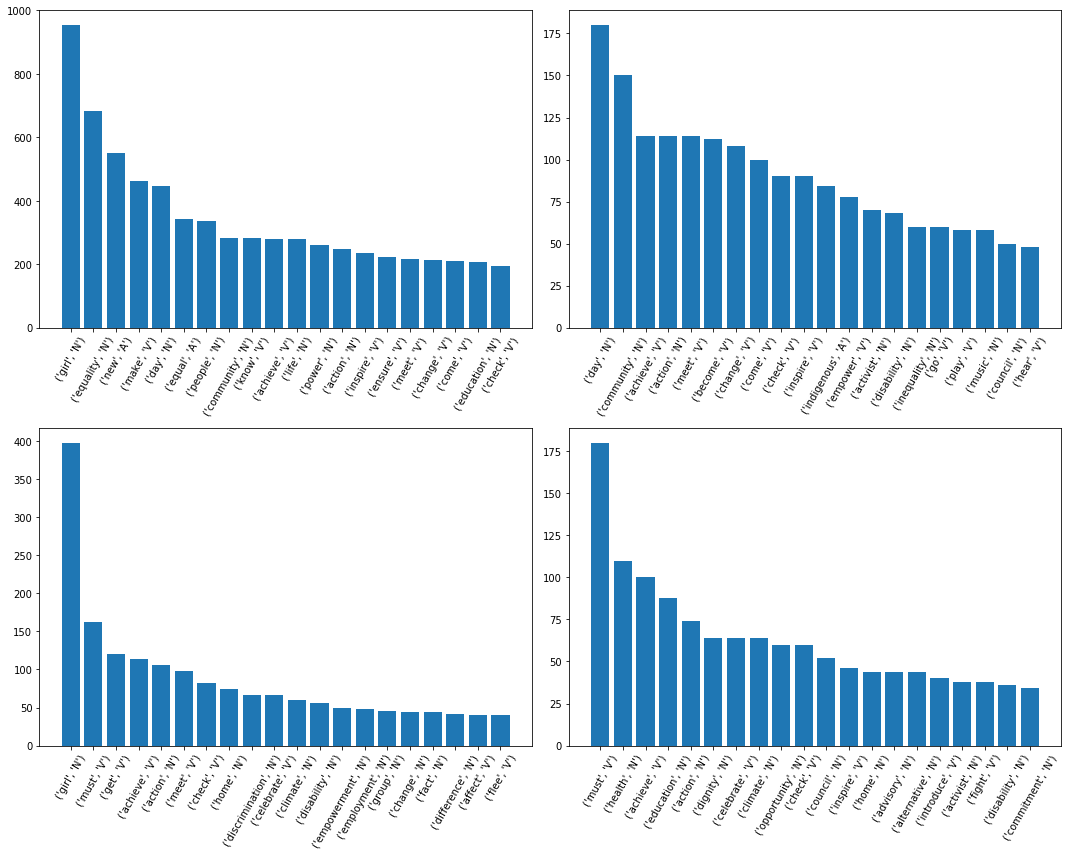

In [14]:
# MCL communities analysis
best = 20 

for i, y in enumerate(years):
    net = networks[y]
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))    
    axs = axs.ravel()
    for j, c in enumerate(mcl_clusters[y][:4]):
        degree = get_degree(nx.induced_subgraph(net, c)).sort_values(ascending=False).iloc[:best]        
        _ = axs[j].bar(degree.index.map(lambda x: str(i2w[x])).values, degree.values)
        _ = axs[j].tick_params(axis='x', labelrotation=60)
    _ = plt.tight_layout()
    _ = plt.show()

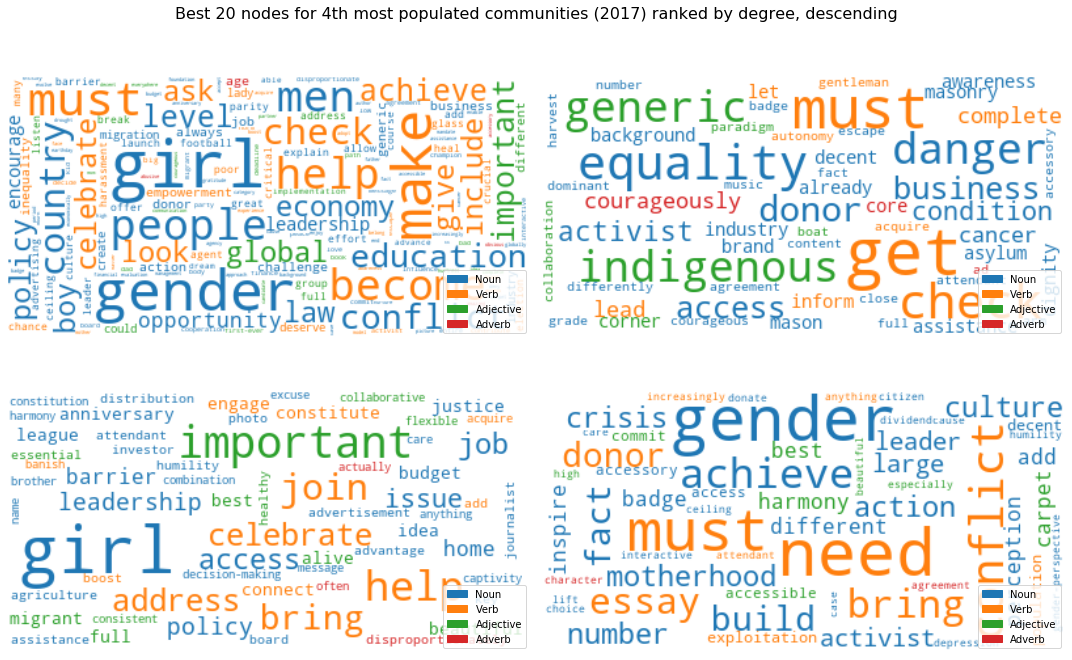

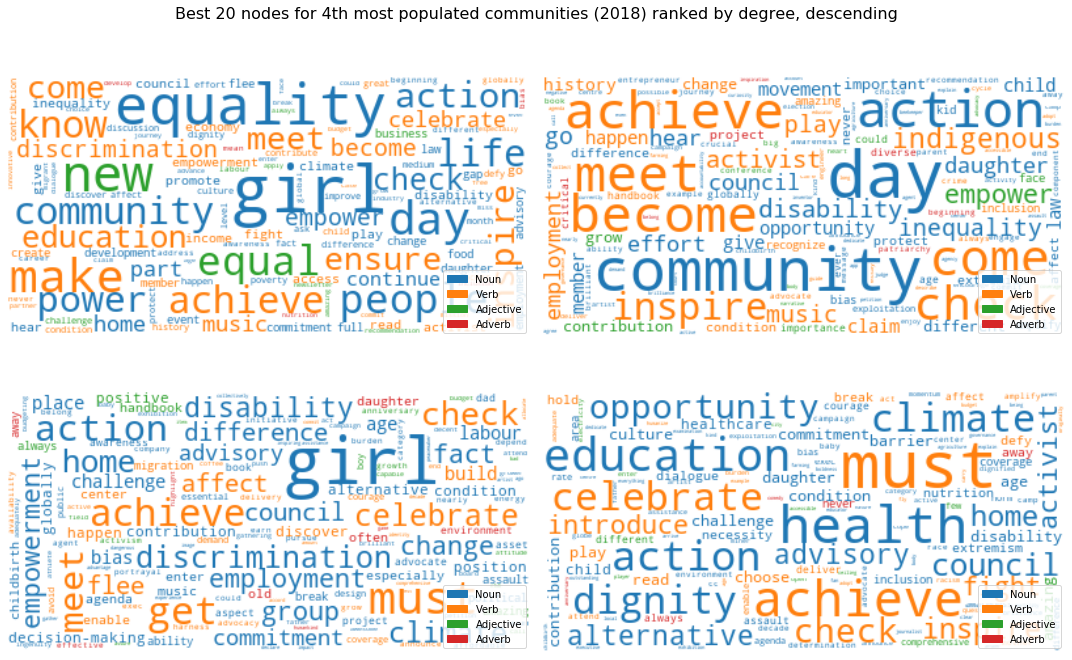

In [18]:
# Plot word clouds
for i, y in enumerate(years):
    # Get nets
    net = networks[y]
    # Define a 2x2 plot for each period (year) under analysis
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))    
    axs = axs.ravel()
    _ = fig.suptitle('Best 20 nodes for 4th most populated communities ({:d}) ranked by degree, descending'.format(y),
                     size=16)
    # Exctract WordCloud object from each cluster
    for j, c in enumerate(mcl_clusters[y][:4]):
        # Get degrees for current cluster
        degree = get_degree(net.subgraph(c)).sort_values(ascending=False)
        # Compute relative degree, needed for word scaling
        degree = degree / degree.sum()
        # Turn index from numeric to tuple (word text, pos_tag)
        degree.index = degree.index.map(lambda i: i2w[i])
        
        # Define a WordCloud object using (word, POS tag) items
        word_cloud = make_word_cloud(
            WordCloud(max_font_size=50, background_color='white'),
            degree
        )
        
        # Make wordcloud plot
        _ = axs[j].imshow(word_cloud, interpolation='bilinear')
        _ = axs[j].set_axis_off()
        _ = axs[j].legend(
            handles=[mpatches.Patch(color=pos_patches[t][0], label=pos_patches[t][1]) for t in pos_patches.keys()], 
            loc='lower right'
        )
    
    # Make plot
    _ = plt.tight_layout()
    _ = plt.subplots_adjust(top=0.95) 
    _ = plt.show()

# Louvain clustering 

In [21]:
# Compute clusters for both nets
partitions = {y: pd.Series(community.best_partition(networks[y])) for y in years}

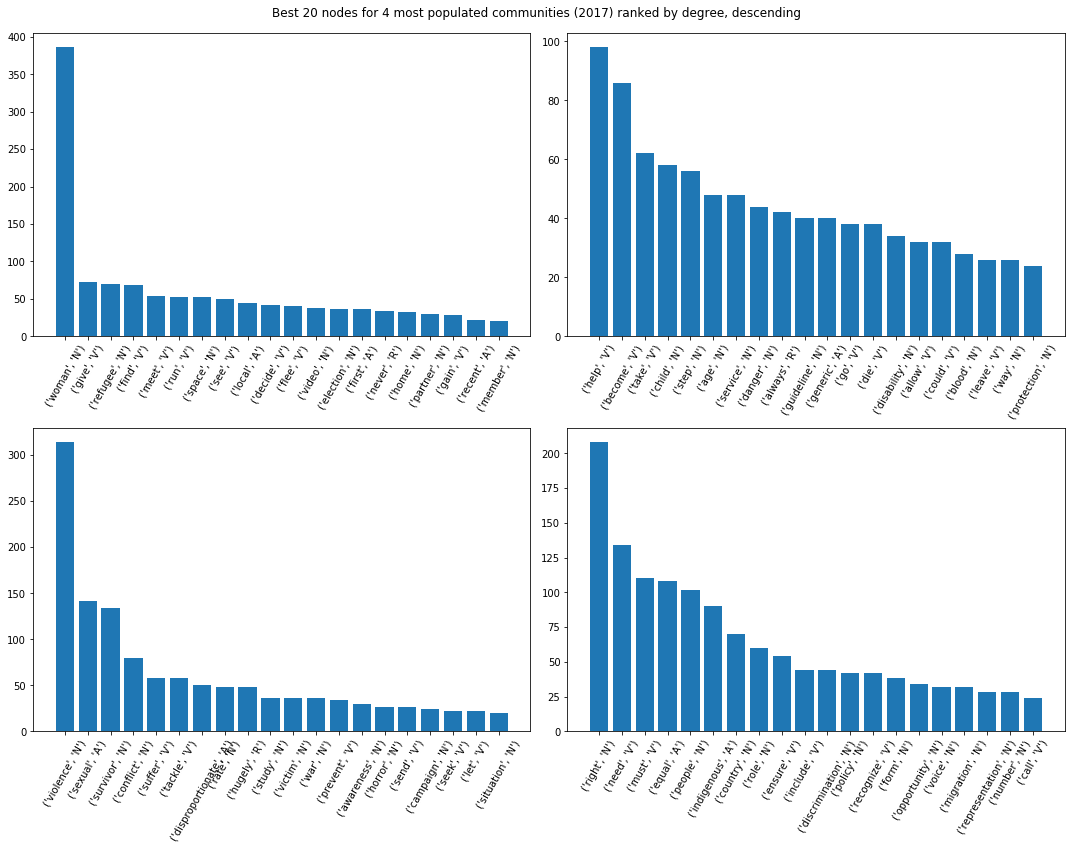

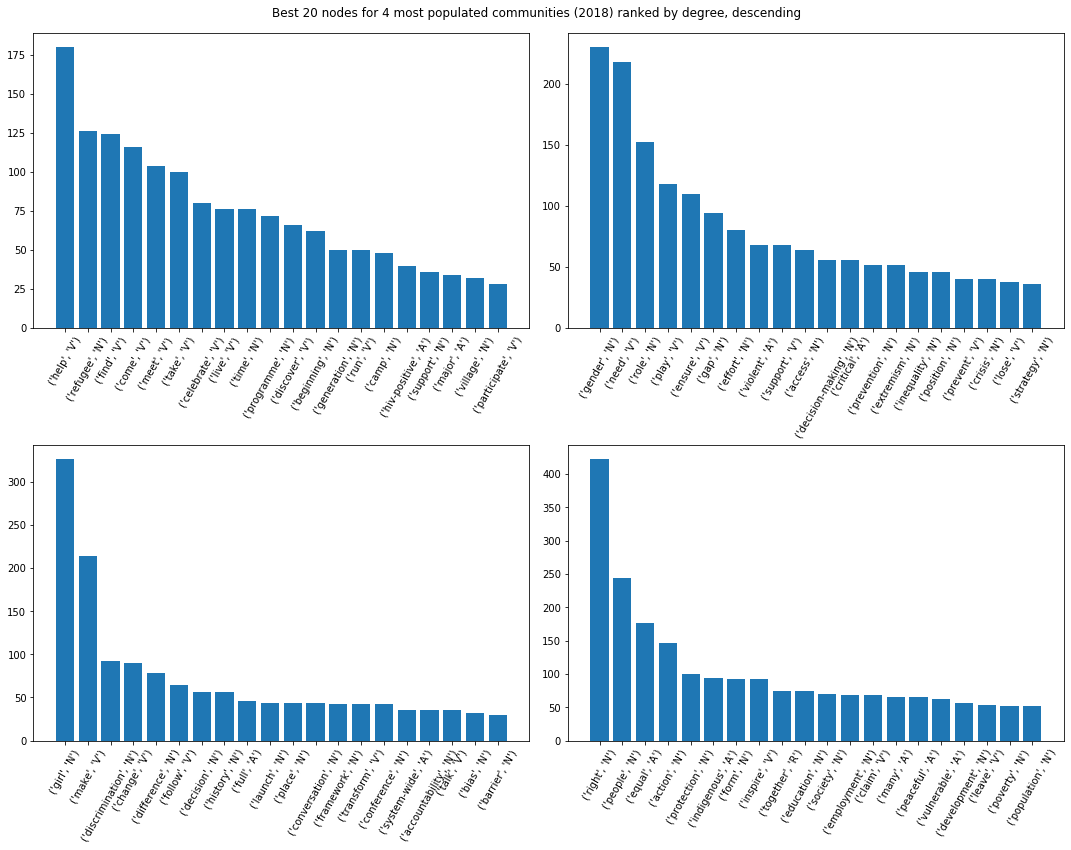

In [22]:
# Louvain communities analysis

best = 20 

for i, y in enumerate(years):
    # Initialize plot
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))    
    axs = axs.ravel()
    # Set title
    _ = fig.suptitle('Best 20 nodes for 4 most populated communities ({:d}) ranked by degree, descending'.format(y))
    # Extract 4 more populated clusters
    clusters = partitions[y].groupby(by=partitions[y]).size().sort_values(ascending=False)
    best_clusters = clusters.iloc[:4]
    # Get nodes for each cluster
    clusters = partitions[y][partitions[y].isin(best_clusters.index)]
    clusters = clusters.groupby(by = clusters)
    # Plot every cluster
    for j, c in enumerate(clusters):
        degree = get_degree(networks[y].subgraph(c[1].index.values)).sort_values(ascending=False).iloc[:best]        
        _ = axs[j].bar(degree.index.map(lambda x: str(i2w[x])).values, degree.values)
        _ = axs[j].tick_params(axis='x', labelrotation=60)
    _ = plt.tight_layout()
    _ = plt.subplots_adjust(top=0.95) 
    _ = plt.show()

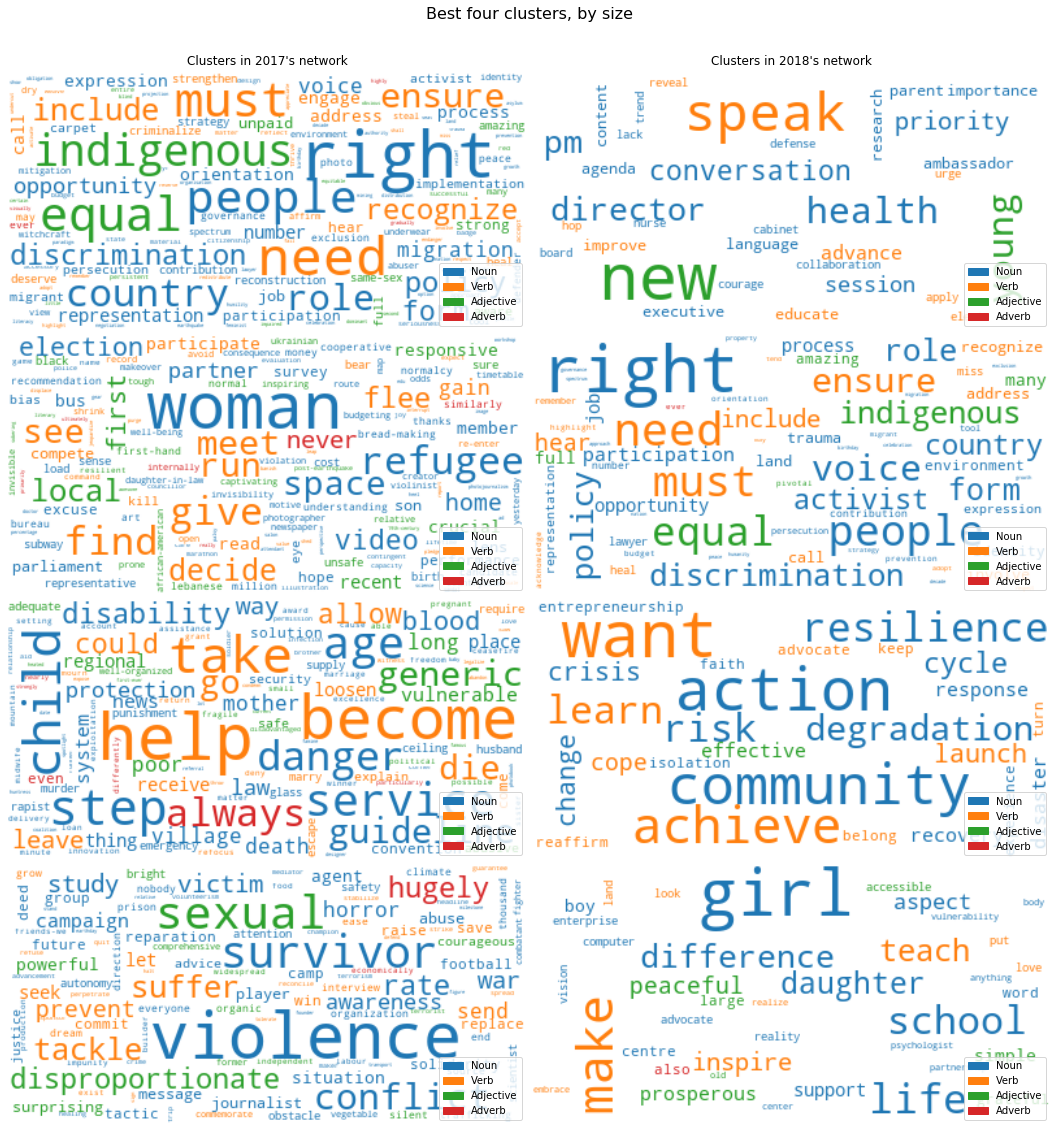

In [28]:
# Define maximum number of clusters and words to visualize for any cluster
num_clusters = 4
num_degrees = 20


# Define a 2x2 plot for each period (year) under analysis
fig, axs = plt.subplots(4, 2, figsize=(15, 15))    
# Add title
_ = fig.suptitle('Best four clusters, by size', size=16, y=1.04)
# Add title on first plot left and first plot right
_ = axs[0, 0].set_title('Clusters in 2017\'s network')
_ = axs[0, 1].set_title('Clusters in 2018\'s network')

# Plot word clouds
for i, y in enumerate(networks.keys()):
    # Get currently analyzed network object
    net = networks[y]
    
    # Extract 4 more populated clusters
    partitions_ = partitions[y]
    clusters = partitions_.groupby(by=partitions_).size().sort_values(ascending=False)
    best_clusters = clusters.index.values[:num_clusters]
    
    # Represent each cluster graphically
    for j, c in enumerate(best_clusters):
        
        # Get current subgraph nodes
        sub_nodes = nodes.index[nodes == c]
        sub_graph = net.subgraph(sub_nodes)
        
        # Get degrees for current cluster
        degree = get_degree(sub_graph).sort_values(ascending=False)
        degree = degree / degree.sum() # Compute relative degree, needed for word scaling
        # Turn index from numeric to tuple (word text, pos_tag)
        degree.index = degree.index.map(lambda i: i2w[i])
        
        # Define a WordCloud object using (word, POS tag) items
        word_cloud = make_word_cloud(WordCloud(max_font_size=50, background_color='white'), degree)
        
        # Make wordcloud plot
        _ = axs[j, i].imshow(word_cloud, interpolation='bilinear')
        _ = axs[j, i].set_axis_off()
        _ = axs[j, i].legend(
            handles=[mpatches.Patch(color=pos_patches[k][0], label=pos_patches[k][1]) for k in pos_patches.keys()], 
            loc='lower right'
        )
        
# Make plot
_ = plt.tight_layout(pad=0.5)
_ = plt.show()